# Gamma Ray Bursts

Capire quelli che sono i vantaggi e gli svantaggi di usare kMeans rispetto a Gaussian Mixture. 
Per esempio gaussian mixture mi dice che ho piccola probabilità di trovare un long gamma ray burst a T90 = 2 mentre perKmeans non è possibile.
oppure con gauusiian mixture non serve definire una treshold

oss:
Gaussian mixture non è un vero e proprio metodo di cluster. Ma usa la pdf per ottenere due categorie.

Guardare questo sito:https://towardsdatascience.com/clustering-out-of-the-black-box-5e8285220717
Potrei calcolare la probabilità di trovare un determinato dato nei due casi

In [1]:
import numpy as np
import scipy.stats as stats
import pylab as plt 
import math

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
data.shape

(15, 8422)

In [5]:
T90=np.array(data[6],dtype=float)
print(T90)

[ 58.625 243.717   0.768 ...   3.136 208.576   5.184]


plt.hist(np.log(T90[T90>0]),bins= 100);

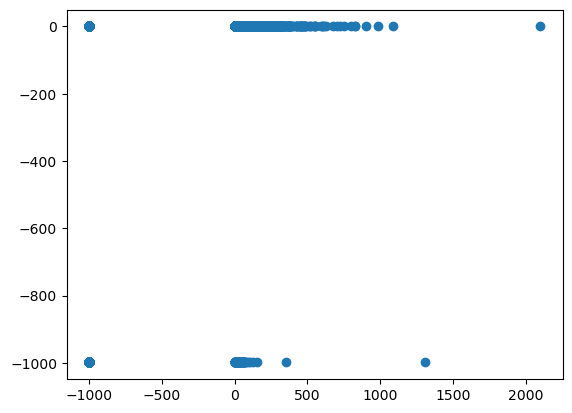

In [6]:
fluence = np.array(data[9],dtype=float)
plt.scatter(T90,fluence)

C:\Users\utente\AppData\Local\Temp\ipykernel_6460\3936962271.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = T90[[np.logical_and(T90 >0, fluence > 0)]]
C:\Users\utente\AppData\Local\Temp\ipykernel_6460\3936962271.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = fluence[[np.logical_and(T90 >0, fluence > 0)]]


Text(0, 0.5, 'Flux')

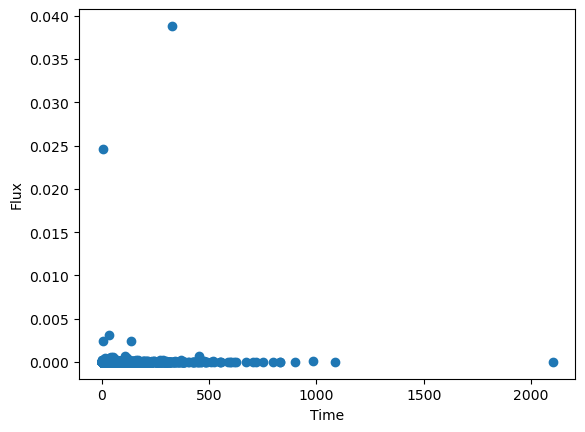

In [7]:
x = T90[[np.logical_and(T90 >0, fluence > 0)]]
y = fluence[[np.logical_and(T90 >0, fluence > 0)]]



plt.scatter(x,y)
plt.xlabel("Time")
plt.ylabel("Flux")
#plt.loglog()

- Does the distribution contain different sub-populations? How many?

Maybe we have two different sub population since we know Gamma Ray Bursts (GRBs) come from supernovae or neutron star mergers.
>*short gamma ray burst* = they come from the neutron star mergers

>*long gamma ray burst* = they come from the supernovae explosion


- What's the threshold between the classes?

- If you try two clustering methods, do you get more or less the same?

In [8]:
X = np.vstack([np.log10(x),np.log10(y)]).T
print(X)

[[ 1.76808286 -5.83710716]
 [ 2.38688582 -4.16427139]
 [-0.11463878 -6.24936049]
 ...
 [ 0.49637605 -7.60453382]
 [ 2.31926433 -6.78225293]
 [ 0.71466499 -5.58410892]]


**KMeans method**

[[ 0.06813658 -6.72526774]
 [ 1.52819405 -5.46205176]]


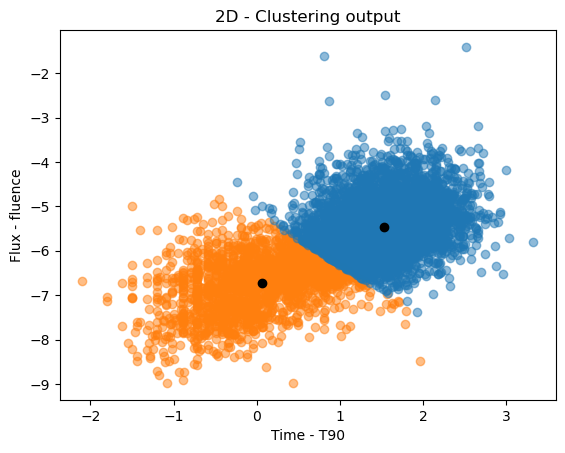

In [9]:
#2D clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing

# n_cluster is an example of hyperparameter
clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1],color=colors[ii],alpha=0.5)

plt.scatter(centers[0,0],centers[0,1], color='Black')
plt.scatter(centers[1,0],centers[1,1], color='Black')

plt.xlabel("Time - T90")
plt.ylabel("Flux - fluence")
plt.title('2D - Clustering output')

print(centers)

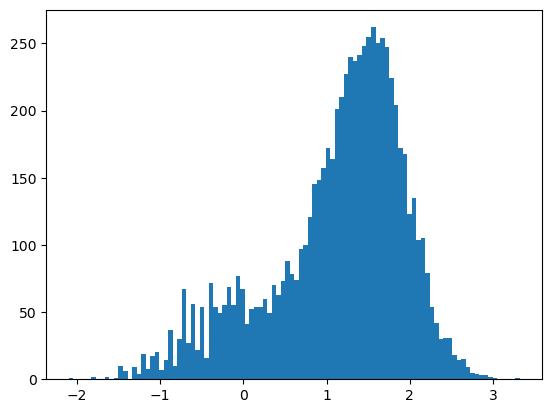

In [10]:
plt.hist(X[:,0],bins=100);

In [11]:
print(x)

[ 58.625 243.717   0.768 ...   3.136 208.576   5.184]


In [12]:
from sklearn.neighbors import KernelDensity

x_plot = np.logspace(-3, 3, 1000)
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(X[:,0].reshape(-1,1))
y_plot= np.exp(kde.score_samples(np.log10((x_plot).reshape(-1,1))))

[]

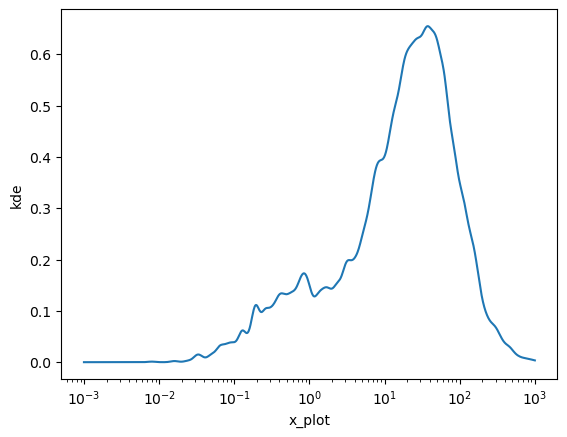

In [13]:
plt.plot(x_plot,y_plot)

plt.xlabel("x_plot")
plt.ylabel("kde")
plt.semilogx()

We suppose that the above signal is generate by 2 different events (models):
- neutron star mergers
- supernovae explosion

The models are taken from `GaussianMixture` and through the calculation of AIC we are able to understand the best *models* that fit the *data*

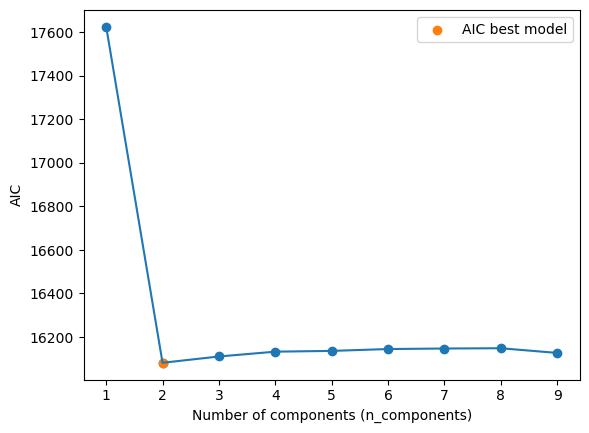

In [14]:
# Take from exercise 'Lezione_06'
from sklearn.mixture import GaussianMixture

N = np.arange(1,10)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(n_components=N[i], random_state=0).fit(X[:,0].reshape(-1,1))
    
#Let's compute the AIC

AIC = [m.aic(X[:,0].reshape(-1,1)) for m in models]
plt.plot(N,AIC)
plt.scatter(N,AIC)
plt.scatter(N[np.argmin(AIC)],AIC[np.argmin(AIC)], label = 'AIC best model')

plt.xlabel('Number of components (n_components)')
plt.ylabel('AIC')
plt.legend()
plt.show()


The best model, following AIC theory, is the model with n_components = 2

In [15]:
M_best = models[np.argmin(AIC)]

Mean: [[ 1.48845959]
 [-0.01138244]]


Text(0.5, 1.0, 'pdf - gaussian mixture')

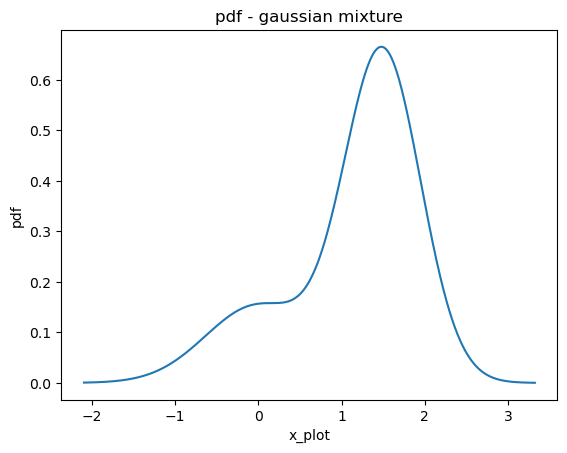

In [16]:
#gm = GaussianMixture(n_components=N, random_state=0).fit(x.reshape(-1,1))
#gm.means_

x_plot = np.linspace(min(X[:,0]),max(X[:,0]),1000)
logy_plot= M_best.score_samples(x_plot.reshape(-1,1))
y_plot = np.exp(logy_plot)


means = GaussianMixture(N[np.argmin(AIC)]).fit(X[:,0].reshape(-1,1)).means_
covs = GaussianMixture(N[np.argmin(AIC)]).fit(X[:,0].reshape(-1,1)).covariances_
weights = GaussianMixture(N[np.argmin(AIC)]).fit(X[:,0].reshape(-1,1)).weights_

print("Mean:",means)

plt.plot(x_plot,y_plot)
plt.xlabel("x_plot")
plt.ylabel("pdf")
plt.title("pdf - gaussian mixture")

[[ 1.48845959]
 [-0.01138244]]


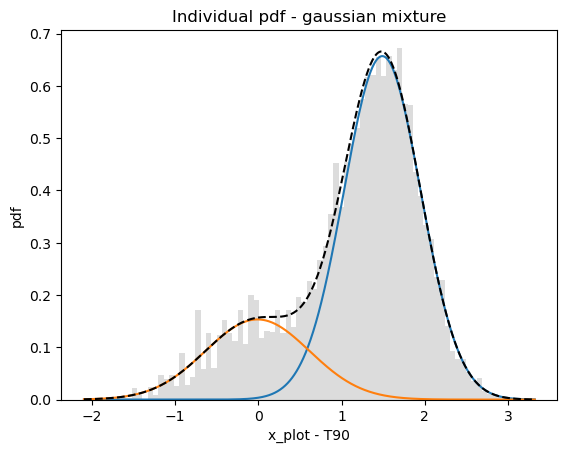

In [17]:
# Take from exercise 'Lezione_06'
responsibilities = M_best.predict_proba(x_plot.reshape(-1,1))
#pdf_individual = responsibilities * y_plot[:, np.newaxis]
pdf_individual = responsibilities * y_plot.reshape(-1,1)

means = GaussianMixture(N[np.argmin(AIC)]).fit(X[:,0].reshape(-1,1)).means_
covs = GaussianMixture(N[np.argmin(AIC)]).fit(X[:,0].reshape(-1,1)).covariances_
weights = GaussianMixture(N[np.argmin(AIC)]).fit(X[:,0].reshape(-1,1)).weights_

plt.hist(X[:,0], bins = int(np.sqrt(len(X))), density = True, color = 'gainsboro')

for i in range(0,N[np.argmin(AIC)]):
    plt.plot(x_plot,pdf_individual[:,i])


print(means)

plt.plot(x_plot,y_plot,'--k')

plt.xlabel("x_plot - T90")
plt.ylabel("pdf")
plt.title("Individual pdf - gaussian mixture")
plt.show()

Let's try to make the Gaussian Mixture, on the 2D plot of fluence-T90.

[[ 1.50175295 -5.51742299]
 [ 0.0546323  -6.64362444]]


Text(0.5, 1.0, '2D - Gaussian Mixture')

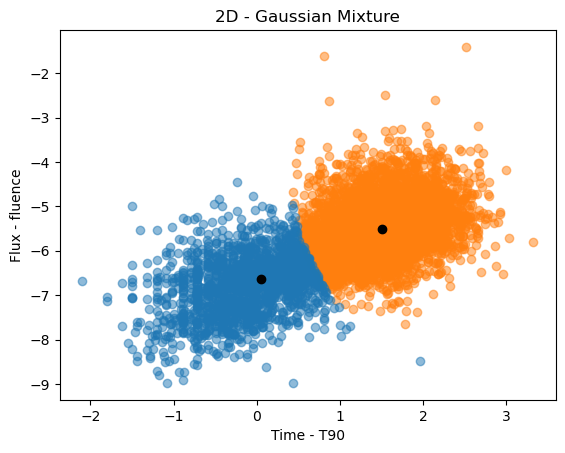

In [29]:
import pandas as pd
from pandas import DataFrame

d = pd.DataFrame(X)

gm1 = GaussianMixture(n_components = N[np.argmin(AIC)]).fit(X)
labels = gm1.predict(X)
print(gm1.means_)#Ciò che mi aspetto sia il centro del cluster

for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1],color=colors[ii],alpha=0.5)
'''
d['labels'] = labels
d0 = d[d['labels']==0]
d1 = d[d['labels']==1]

plt.scatter(d0[0],d0[1],c='r',alpha=0.5)
plt.scatter(d1[0],d1[1],c='g',alpha=0.5)
'''
plt.scatter(gm1.means_[0,0],gm1.means_[0,1], color='Black')
plt.scatter(gm1.means_[1,0],gm1.means_[1,1], color='Black')

plt.xlabel("Time - T90")
plt.ylabel("Flux - fluence")
plt.title('2D - Gaussian Mixture')


Provo a vedere se esistono alte correlazioni oltre alla distinzione del tempo, per esempio con redshift.